In [30]:
%matplotlib inline

import numpy as np
import collections
from collections import OrderedDict, Counter, defaultdict
import pandas as pd

import Bio
from Bio import SeqIO
from Bio.Seq import Seq

import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_file, show 
import matplotlib.patches as patches    
from matplotlib import colors


import glob

import subprocess
from subprocess import call

import re

import pickle

#from Bio.SubsMat import MatrixInfo
#import Bio.Data.CodonTable

from scipy import stats


from Bio.SubsMat import MatrixInfo
import Bio.Data.CodonTable

#import joypy

import pyBigWig

# Metadata 

In [31]:
metadata_pc_g25 =  pd.read_csv('/home/alla/make_PhD_great_again/NTE/VERSION_since_May2021/tmp_res/metadata_pc_g25.txt', sep='\t')
metadata_pc_g25['tr_id1'] = [x.split('.')[0] for x in metadata_pc_g25['tr_id'].tolist()]


gtf = pd.read_csv('DATA/gencode.v25.annotation.gtf', sep='\t', comment='#', header=None)
gtf_tr = gtf[gtf[2] == 'transcript'] 
gtf_tr['tr_id'] = [x.split('transcript_id ')[1].split('"')[1] for x in gtf_tr[8].tolist()]
gtf_tr['tr_id1'] = [x.split('.')[0] for x in gtf_tr['tr_id'].tolist()]


/tmp/ipykernel_154493/3310476455.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gtf_tr['tr_id'] = [x.split('transcript_id ')[1].split('"')[1] for x in gtf_tr[8].tolist()]
/tmp/ipykernel_154493/3310476455.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gtf_tr['tr_id1'] = [x.split('.')[0] for x in gtf_tr['tr_id'].tolist()]


# We need to select reasonable rank for each category to make a cutoff 

In [32]:
# rank 5000
uORF_df = pd.read_csv('DATA/NonCanonicalORFs_Trips-viz_10studies_100samples_1000/AUG_uORF_1000_10studies.csv')

# rank y
uoORF_df = pd.read_csv('DATA/NonCanonicalORFs_Trips-viz_10studies_100samples_1000/AUG_uoORF_1000_10studies.csv')

# rank x
doORF_df = pd.read_csv('DATA/NonCanonicalORFs_Trips-viz_10studies_100samples_1000/AUG_doORF_1000_10studies.csv')

# rank u
dORF_df = pd.read_csv('DATA/NonCanonicalORFs_Trips-viz_10studies_100samples_1000/AUG_dORF_1000_10studies.csv')

# rank a
lncORF_df = pd.read_csv('DATA/NonCanonicalORFs_Trips-viz_10studies_100samples_1000/AUG_lncORF_1000_10studies.csv')


In [33]:
# rank 
nORF_df = pd.read_csv('DATA/NonCanonicalORFs_Trips-viz_10studies_100samples_1000/AUG_nORF_1000_10studies.csv').drop_duplicates()
nORF_df.columns = ['Gene', 'tr_id1', 'Start', 'Stop', 'Length', 'Global_Rank', 'Type',
       'Trips-viz link', 'Start Codon', 'Highframe rank', 'Highframe value',
       'Lowframe rank', 'Lowframe value', 'Stop rank', 'Stop value',
       'Start rank', 'Start value', 'Coverage rank', 'Coverage value',
       'Inframe Count Rank', 'Inframe Count Value', 'Amino acid sequence',
       'Proteomics count', 'Read density']

# filter reading frame of nORFs 
nORF_df[0:2]

nORF_df1 = nORF_df.merge(metadata_pc_g25[['tr_id1', 'cds_start_pos']],
                        on='tr_id1', how='inner').drop_duplicates()


li = []
for el in nORF_df1[['tr_id1', 'Start', 'cds_start_pos']].to_numpy():
    tr_id1 = el[0]
    start = el[1]-1
    cds_start = el[2]
    
    if (cds_start % 3) == (start % 3):
        # same frame 
        frame = 'the same'
    else:
        frame = 'different'
        
    li.append([tr_id1, el[1], frame])
    
frame_df = pd.DataFrame(li, columns = ['tr_id1', 'Start', 'frame'])
    
nORF_df2 = nORF_df1.merge(frame_df,
                         on=['tr_id1', 'Start'], how='inner').drop_duplicates()


# if frame is the same it's probably lncRNA or wrong CDS annotation with no 5'UTR
nORF_df3 = nORF_df2[nORF_df2['frame'] == 'different']

print (nORF_df2.shape[0], nORF_df1.shape[0], nORF_df.shape[0], nORF_df3.shape[0])

# pseudogenes
# set(nORF_df.tr_id1.tolist()) - set(nORF_df2.tr_id1.tolist())

145334 145334 145448 145240


# Combine all ORFs together using rank 

In [34]:
uORF_sel = uORF_df[['Gene', 'Tran', 'Start', 'Stop', 'Global_Rank', 'Type', 
         'Amino acid sequence']]#[0:5000]

uORF_sel.columns = ['Gene', 'tr_id1', 'Start', 
                    'Stop', 'Global_Rank_within_ORF_type', 
                    'Type_of_ORF', 'Amino acid sequence']

In [35]:
nORF_sel = nORF_df3[['Gene', 'tr_id1', 'Start', 'Stop', 'Global_Rank', 'Type', 
         'Amino acid sequence']]#[0:100]

nORF_sel.columns = ['Gene', 'tr_id1', 'Start', 
                    'Stop', 'Global_Rank_within_ORF_type', 
                    'Type_of_ORF', 'Amino acid sequence']

In [36]:
uoORF_sel = uoORF_df[['Gene', 'Tran', 'Start', 'Stop', 'Global_Rank', 'Type', 
         'Amino acid sequence']]#[0:550]

uoORF_sel.columns = ['Gene', 'tr_id1', 'Start', 
                    'Stop', 'Global_Rank_within_ORF_type', 
                    'Type_of_ORF', 'Amino acid sequence']

In [135]:
dORF_sel = dORF_df[['Gene', 'Tran', 'Start', 'Stop', 'Global_Rank', 'Type', 
         'Amino acid sequence']]

dORF_sel.columns = ['Gene', 'tr_id1', 'Start', 
                    'Stop', 'Global_Rank_within_ORF_type', 
                    'Type_of_ORF', 'Amino acid sequence']

In [136]:
doORF_sel = doORF_df[['Gene', 'Tran', 'Start', 'Stop', 'Global_Rank', 'Type', 
         'Amino acid sequence']]

doORF_sel.columns = ['Gene', 'tr_id1', 'Start', 
                    'Stop', 'Global_Rank_within_ORF_type', 
                    'Type_of_ORF', 'Amino acid sequence']

In [138]:
lncORF_sel = lncORF_df[['Gene', 'Tran', 'Start', 'Stop', 'Global_Rank', 'Type', 
         'Amino acid sequence']][0:2800]

lncORF_sel.columns = ['Gene', 'tr_id1', 'Start', 
                    'Stop', 'Global_Rank_within_ORF_type', 
                    'Type_of_ORF', 'Amino acid sequence']

In [139]:
comb = pd.concat([uORF_sel, uoORF_sel, nORF_sel, 
                  doORF_sel, 
                  dORF_sel])

In [140]:
comb_df = comb.merge(metadata_pc_g25[['tr_id1', 'tr_id']], on='tr_id1', how='inner').drop_duplicates()

comb_df = comb_df[~comb_df['tr_id'].str.contains('PAR')]

print (comb_df.shape[0])

400862


In [141]:
lncORF_sel2 = lncORF_sel.merge(gtf_tr[['tr_id', 'tr_id1']], on='tr_id1', how='inner')

lncORF_sel.shape[0], lncORF_sel2.shape[0]

(2800, 2800)

In [142]:
total = pd.concat([comb_df, lncORF_sel2], axis=0)

In [143]:
total.to_csv('tmp_res/all_ncORFs.txt', sep='\t', index=False)

In [144]:
total['group'] = list(range(1, total.shape[0]+1))

# GENOMIC COO 

In [145]:
def prepare_global_coo(path_to_file_with_global_coo, colname):
    global_coo_g25 = pd.read_csv(path_to_file_with_global_coo, sep='\t')
    global_coo_g25_f = global_coo_g25[global_coo_g25['hit'] == True]
    global_coo_g25_f = global_coo_g25_f.sort_values(by=['seqnames', 'start'])
    
    global_coo_g25_f['global_coo'] = global_coo_g25_f['seqnames']+':'+global_coo_g25_f['start'].astype(str) +'-'+global_coo_g25_f['end'].astype(str)
    global_coo_g25_f = global_coo_g25_f[['group', 'group_name', 'strand', 'global_coo']].groupby(['group', 'group_name', 'strand']).agg('+'.join).reset_index()
    global_coo_g25_f.columns = ['group', 'tr_id', 'strand', colname]
    return global_coo_g25_f

In [146]:
all_ORFs_coo = prepare_global_coo(path_to_file_with_global_coo='tmp_res/all_ncORFs_global.txt',
                                   colname = 'global_coo')



In [148]:
total_global = total.merge(all_ORFs_coo, on=['tr_id', 'group'], how='inner')

total_global.to_csv('tmp_res/all_ncORFs_with_global_coo.txt', sep='\t', index=False)

total_global.shape[0],total_global['Amino acid sequence'].nunique(), total_global['global_coo'].nunique()

(403662, 394997, 400476)

# Group ncORFs based on genomic coordinates (e.g. [nORF,uORF], [tr_id1,tr_id2]) -> how many ncORFs unique by genomic coo and aa?

In [149]:
total_global = total.merge(all_ORFs_coo, on=['tr_id', 'group'], how='inner')

total_global['Start'] = total_global['Start'].astype(str)

total_global['Stop'] = total_global['Stop'].astype(str)

total_global['Global_Rank_within_ORF_type'] = total_global['Global_Rank_within_ORF_type'].astype(str)

total_global.shape[0]

403662

# Overlap with HLA-peptidomics data 

In [50]:
# only unique aa sequences 

unique_aa = list(total_global['Amino acid sequence'].unique())

print (len(unique_aa))

599498


In [24]:
df = pd.read_csv('DATA/Novels_forAlla.txt', sep='\t')
df[0:4]

,Peptide,Gene_Names,BestPSM_PEP,ENST_ids,Protein_Accessions,Chromosome/scaffold name,Gene start (bp),Gene end (bp),Parsed_Loci
0,AAAAPESF,CIZ1,0.010166,ENST00000476727,NonCoding_2_ENST00000476727_ENSG00000148337,9,128161251,128204383,-
1,AADGHHRGL,HSPBP1,0.001552,"ENST00000255631,ENST00000433386,ENST0000058569...","10_ENST00000255631_ENSG00000133265_F1_orf2,10_...",19,55262223,55280381,-
2,AADHGPDEY,POMK,0.001915,"ENST00000331373,ENST00000518991,ENST0000061442...","19_ENST00000331373_ENSG00000185900_F2_orf2,19_...",8,43093498,43131180,-
3,AAEPVDSSL,-,0.046727,-,ERV_1792085_ERVL-E-int::chr18:74213725-74215142_6,-,-,-,chr18:74213725-74215142


In [25]:
li = []

for i, aa in enumerate(unique_aa):
    for peptide in df['Peptide'].tolist():
        if aa.find(peptide) != -1:
            li.append([aa, peptide, aa.find(peptide)])
    if i % 1000 == 0:
        print (i)
            

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [28]:
outdf = pd.DataFrame(li, columns = ['aa', 'peptide', 'pos'])

In [29]:
outdf

,aa,peptide,pos
0,MQLLRSSNAAELEAEAAGEVRAM,AEAAGEVRA,13
1,MAARSSSGVAAAEGAAALAAAETAAVTVAAAARDLGLGE,AETAAVTVA,20
2,MAARSSSGVAAAEGAAALAAAETAAVTVAAAARDLGLGE,AETAAVTVAA,20
3,MAARSSSGVAAAEGAAALAAAETAAVTVAAAARDLGLGE,AETAAVTVAAA,20
4,MEVASVAAYCAGCSSLCSAARCRIRCPLWLFCWLEDRPGAATPPLG...,MEVASVAA,0
...,...,...,...
214,MNQKKKKKIKYKHCLSIKCCSLPRRKGTPSNHEILWYSQESDPQTK...,SQESDPQTKS,37
215,MVSLKKQATAPSTSTQAVPSLWMEVLMWRRKFWKMMVSQVVLDKGS...,WRRKFWKMMVSQVVL,27
216,MVSLKKQAMAPSTSTQAVPSLWMEVLVWRRKFWKMMVSQVVLDKGS...,WRRKFWKMMVSQVVL,27
217,MDFKDLKEVKYHKMEELESLNHCV,KDLKEVKY,3


In [51]:
def prepare_data_for_trips2(meta, file_counts, metadata_pc_g25, 
                           tr_id, gene, l, p, fraq, cds, name, 
                           predicted_ext_start=False, figsize=(20, 10),
                           xlims='full', zeros=True, linew=9):
    
    f = pd.read_csv(file_counts)
    f.columns = ['Position', 'Sequence', 'Frame1', 'Frame2', 'Frame3', 'RNASeq']
    
    if f.iloc[0].Position == 1:
        f['Position'] = list(range(0, f.shape[0]))
    
    atgs_pos = {'frame_0':[], 'frame_1':[], 'frame_2':[]}
    stop_pos = {'frame_0':[], 'frame_1':[], 'frame_2':[]}

    for pos in f.Position.tolist():
        codon = ''.join(f.Sequence.tolist()[(pos-1):(pos-1+3)])
        if codon == 'ATG':
            if pos % 3 == 0:
                atgs_pos['frame_0'].append(pos)
            elif pos % 3 == 1:
                atgs_pos['frame_1'].append(pos)
            else:
                atgs_pos['frame_2'].append(pos)
            
        elif (codon == 'TGA') | (codon == 'TAA') | (codon == 'TAG'):
            if pos % 3 == 0:
                stop_pos['frame_0'].append(pos)
            elif pos % 3 == 1:
                stop_pos['frame_1'].append(pos)
            else:
                stop_pos['frame_2'].append(pos)
        else:
            continue     
            
    # add CDS borders
    cds_stop_pos = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
    cds_start_pos = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos + 1
    cds_start_codon = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_codon
    
    if xlims == 'ext':
        xlim1 = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1
        xlim2 = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_end1 + 50*3
    elif len(xlims) == 2:
        xlim1 = xlims[0]
        xlim2 = xlims[1]
    else: # full transcript
        xlim1 = 0
        xlim2 = len(metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq)
    
    d = {}
    
    d['cds_stop_pos'] = cds_stop_pos
    d['cds_start_pos'] = cds_start_pos
    d['cds_start_codon'] = cds_start_codon
    d['f'] = f
    d['stop_pos'] = stop_pos
    d['atgs_pos'] = atgs_pos
    d['xlims'] = (xlim1, xlim2)
    d['predicted_ext_start'] = predicted_ext_start
    d['l'] = l
    d['p'] = p
    d['figsize'] = figsize
    d['fraq'] = fraq
    d['cds'] = cds
    d['name'] = tr_id+'_'+gene
    d['zeros'] = zeros
    d['linew'] = linew
    
    return d


def trips_full2(d, name='test', font1=38, font2=45):
    
    l = d['l']
    p = d['p']
    f = d['f'] # dict with frames 
    atgs_pos = d['atgs_pos']
    stop_pos = d['stop_pos']
    cds_start_pos = d['cds_start_pos']
    cds_stop_pos = d['cds_stop_pos']
    figsize = d['figsize']
    xlims = d['xlims']
    fraq = d['fraq']
    cds = d['cds']
    name = d['name']
    zeros = d['zeros']
    linewidth = d['linew'] 
    
    fig, axes = plt.subplots(5, 1, figsize = figsize, 
                             gridspec_kw={'height_ratios':[10,1.5,1,1,1]}, sharex=True, sharey=False, )

    main_plot = axes[0]
    #cds = axes[1]
    orfs = axes[1]
    red = axes[2]
    green = axes[3]
    blue = axes[4]

    # x 
    main_plot.set_xlim(f.Position.min(), f.Position.max()+1)

    # y
    
    if xlims is not False:
        f1 = f[xlims[0]:xlims[1]]
        max_height = np.max([np.max(f1.Frame1.tolist()), np.max(f1.Frame2.tolist()), np.max(f1.Frame3.tolist())])
        print (max_height)
    else:
        max_height = np.max([np.max(f.Frame1.tolist()), np.max(f.Frame2.tolist()), np.max(f.Frame3.tolist())])
        print (max_height)
        
    #### ????? why they dissappear????? ######    
    main_plot.set_ylim(0, max_height+max_height/l)
    main_plot.set_yticks(np.arange(0, max_height+max_height/l, p))
    main_plot.set_yticklabels(np.arange(0, max_height+max_height/l, p, dtype=np.int64), fontsize=font1)
    
    # print (f[125:150])

    # #frame 1 = red, frame2 = green, frame3 = blue
    if zeros == True:
        main_plot.plot(f.Frame1.tolist(), color = 'crimson', linewidth=linewidth, linestyle='-')
        main_plot.plot(f.Frame2.tolist(), color = 'goldenrod', linewidth=linewidth, linestyle='-')
        main_plot.plot(f.Frame3.tolist(), color = 'dodgerblue', linewidth=linewidth, linestyle='-')
    
    else:
        # delete zeros 
        t = f[['Position', 'Frame1']]
        fr1 = t[t['Frame1'] != 0]
        
        t = f[['Position', 'Frame2']]
        fr2 = t[t['Frame2'] != 0]
        
        t = f[['Position', 'Frame3']]
        fr3 = t[t['Frame3'] != 0]
        
        main_plot.plot(fr1.Position.tolist(), fr1.Frame1.tolist(), color = 'crimson', linewidth=linewidth, linestyle='-')
        main_plot.plot(fr2.Position.tolist(), fr2.Frame2.tolist(), color = 'goldenrod', linewidth=linewidth, linestyle='-')
        main_plot.plot(fr3.Position.tolist(), fr3.Frame3.tolist(), color = 'dodgerblue', linewidth=linewidth, linestyle='-')
    
     
    red.set_facecolor('crimson')
    green.set_facecolor('goldenrod')
    blue.set_facecolor('dodgerblue')
    #cds.set_facecolor('lightgrey')

    #blue.set_xticks(np.arange(0, f.Position.max(), 50))
    #blue.set_xticklabels(np.arange(0, f.Position.max(), 50), fontsize=45)

    red.set_yticklabels(())
    green.set_yticklabels(())
    blue.set_yticklabels(())
    #cds.set_yticklabels(())
    orfs.set_yticklabels(())
    
    

    blue.set_ylabel('f2', fontsize=font1)#, rotation = 0)
    red.set_ylabel('f0', fontsize=font1)#, rotation = 0)
    green.set_ylabel('f1', fontsize=font1)#, rotation = 0)
    #cds.set_ylabel('cds', fontsize=35)#, rotation = 0)
    orfs.set_ylabel('orf', fontsize=font1)#, rotation = 0)

    for frame, pos_li in atgs_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
            
    for frame, pos_li in stop_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
            
                    
    # add start of annotated CDS
    main_plot.vlines(cds_stop_pos, ymin=0, ymax=max_height+max_height/l, colors='black', linewidth=linewidth-2)
    main_plot.vlines(cds_start_pos, ymin=0, ymax=max_height+max_height/l, colors='black', linewidth=linewidth-2)
    #main_plot.text(x = cds_stop_pos-100, y = max_height+max_height/10, s = 'cds stop', fontsize=39)
    #main_plot.text(x = cds_start_pos-10, y = max_height+0.1, s = 'cds start', fontsize=39)


    # add rectangle = CDS or ORF
    #if orf is not None:
        #r#ect = patches.Rectangle((cds_start_pos, 0),cds_stop_pos-cds_start_pos,
                         #1,linewidth=1,edgecolor='r',facecolor='lightgrey')
        #cds.add_patch(rect)

        # add non-AUG - cds_start_pos
        #cds.text(x = cds_start_pos, y = 0.3, s = 'AUG', fontsize=38)
    #p#rint ('NAME:', name)
    
    # add rectangle = extended CDS
    xlims = d['xlims']
    predicted_ext_start = d['predicted_ext_start']
    if xlims is not False:
        if predicted_ext_start is not False:
            Nst = int(predicted_ext_start.split('_')[0])
            codon_name = predicted_ext_start.split('_')[1]
            N2 = cds_stop_pos
            
            if name == 'ENST00000381140_GTF3A':
                N2 = 454 #stop codon of overlapping out-of-frame ORF 
                rect = patches.Rectangle((415, 0), N2-415,1,linewidth=1,edgecolor='b',facecolor='silver')
                orfs.add_patch(rect)
                orfs.text(x = Nst, y = 0.3, s = codon_name, fontsize=font1)
                    
            elif name == 'ENST00000265806_R3HCC1':
                Nst = 288
                N2 = 420
                rect = patches.Rectangle((Nst, 0), N2-Nst,1,linewidth=1,edgecolor='r',facecolor='silver')
                orfs.add_patch(rect)
                orfs.text(x = Nst, y = 0.3, s = 'AUG', fontsize=font1)
                
            elif name == 'ENST00000472232_BAG1':
                Nst = 254 
                N2 = 302
                rect = patches.Rectangle((Nst, 0), N2-Nst,1,linewidth=1,edgecolor='r',facecolor='silver')
                orfs.add_patch(rect)
                orfs.text(x = Nst, y = 0.3, s = 'AUG', fontsize=font1)

            else:
                rect = patches.Rectangle((Nst, 0), N2-Nst,1,linewidth=1,edgecolor='r',facecolor='silver')
                orfs.add_patch(rect)
                orfs.text(x = Nst, y = 0.3, s = codon_name, fontsize=font1)
                
                
                

    
    blue.set_xticks(range(f.Position.min(), f.Position.max()+1, fraq))       
    blue.set_xticklabels(range(f.Position.min(), f.Position.max()+1, fraq), fontsize=font1)
    
    print (f.Position.min())
    
    
    if xlims is not False:    
        plt.xlim(xlims[0], xlims[1])
        
        
    main_plot.set_title(name, fontsize=font2)
    plt.subplots_adjust(left=0.1, bottom=0.1,
                    wspace=0.1, hspace=0.1)
    
    plt.savefig('tmp_res/plots/'+name+'.png', dpi = 300, bbox_inches = 'tight')
    

In [88]:
def prepare_data_for_trips_frames_no_CDS(meta, file_counts, metadata_pc_g25, 
                           tr_id, gene, l, p, fraq, cds, name, 
                           predicted_ext_start=False, figsize=(20, 10),
                           xlims='full', zeros=True, linew=9, 
                                         frames=[1,2,3], ylim=None, cds_stop_pos_plot=False):
    
    f = pd.read_csv(file_counts)
    f.columns = ['Position', 'Sequence', 'Frame1', 'Frame2', 'Frame3', 'RNASeq']
    
    if f.iloc[0].Position == 1:
        f['Position'] = list(range(0, f.shape[0]))
    
    atgs_pos = {'frame_0':[], 'frame_1':[], 'frame_2':[]}
    stop_pos = {'frame_0':[], 'frame_1':[], 'frame_2':[]}

    for pos in f.Position.tolist():
        codon = ''.join(f.Sequence.tolist()[(pos-1):(pos-1+3)])
        if codon == 'ATG':
            if pos % 3 == 0:
                atgs_pos['frame_0'].append(pos)
            elif pos % 3 == 1:
                atgs_pos['frame_1'].append(pos)
            else:
                atgs_pos['frame_2'].append(pos)
            
        elif (codon == 'TGA') | (codon == 'TAA') | (codon == 'TAG'):
            if pos % 3 == 0:
                stop_pos['frame_0'].append(pos)
            elif pos % 3 == 1:
                stop_pos['frame_1'].append(pos)
            else:
                stop_pos['frame_2'].append(pos)
        else:
            continue     
            
    # add CDS borders
    try:
        cds_stop_pos = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
        cds_start_pos = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos + 1
        cds_start_codon = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_codon
    except: 
        cds_stop_pos = None
        cds_start_pos = None
        cds_start_codon = None
        
    
    if xlims == 'ext':
        xlim1 = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1
        xlim2 = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_end1 + 50*3
    elif len(xlims) == 2:
        xlim1 = xlims[0]
        xlim2 = xlims[1]
    else: # full transcript
        xlim1 = 0
        xlim2 = len(metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq)
    
    d = {}
    
    d['cds_stop_pos'] = cds_stop_pos
    d['cds_start_pos'] = cds_start_pos
    d['cds_start_codon'] = cds_start_codon
    d['f'] = f
    d['stop_pos'] = stop_pos
    d['atgs_pos'] = atgs_pos
    d['xlims'] = (xlim1, xlim2)
    d['predicted_ext_start'] = predicted_ext_start
    d['l'] = l
    d['p'] = p
    d['figsize'] = figsize
    d['fraq'] = fraq
    d['cds'] = cds
    d['name'] = tr_id+'_'+gene
    d['zeros'] = zeros
    d['linew'] = linew
    d['frames'] = frames
    d['ylim'] = ylim
    d['cds_stop_pos_plot'] = cds_stop_pos_plot 
    
    return d


def trips_full_frames(d, name='test', font1=38, font2=45):
    
    l = d['l']
    p = d['p']
    f = d['f'] # dict with frames 
    atgs_pos = d['atgs_pos']
    stop_pos = d['stop_pos']
    cds_start_pos = d['cds_start_pos']
    cds_stop_pos = d['cds_stop_pos']
    figsize = d['figsize']
    xlims = d['xlims']
    fraq = d['fraq']
    cds = d['cds']
    name = d['name']
    zeros = d['zeros']
    linewidth = d['linew'] 
    frames = d['frames']
    ylim = d['ylim']
    cds_stop_pos_plot = d['cds_stop_pos_plot']
    
    fig, axes = plt.subplots(5, 1, figsize = figsize, 
                             gridspec_kw={'height_ratios':[10,1.5,1,1,1]}, sharex=True, sharey=False, )

    main_plot = axes[0]
    #cds = axes[1]
    orfs = axes[1]
    red = axes[2]
    green = axes[3]
    blue = axes[4]

    # x 
    main_plot.set_xlim(f.Position.min(), f.Position.max()+1)

    # y
    
    if xlims is not False:
        f1 = f[xlims[0]:xlims[1]]
        max_height = np.max([np.max(f1.Frame1.tolist()), np.max(f1.Frame2.tolist()), np.max(f1.Frame3.tolist())])
        print (max_height)
    else:
        max_height = np.max([np.max(f.Frame1.tolist()), np.max(f.Frame2.tolist()), np.max(f.Frame3.tolist())])
        print (max_height)
        
    #### ????? why they dissappear????? ######    
    if ylim is None:
        main_plot.set_ylim(0, max_height+max_height/l)
        main_plot.set_yticks(np.arange(0, max_height+max_height/l, p))
        main_plot.set_yticklabels(np.arange(0, max_height+max_height/l, p, dtype=np.int64), fontsize=font1)
    else:
        main_plot.set_ylim(0, ylim)
        main_plot.set_yticks(np.arange(0, ylim, p))
        main_plot.set_yticklabels(np.arange(0, ylim, p, dtype=np.int64), fontsize=font1)
        
    
    # print (f[125:150])

    # #frame 1 = red, frame2 = green, frame3 = blue
    if zeros == True:
        if 1 in frames:
            main_plot.plot(f.Frame1.tolist(), color = 'crimson', linewidth=linewidth, linestyle='-')
        if 2 in frames:
            main_plot.plot(f.Frame2.tolist(), color = 'goldenrod', linewidth=linewidth, linestyle='-')
        if 3 in frames:
            main_plot.plot(f.Frame3.tolist(), color = 'dodgerblue', linewidth=linewidth, linestyle='-')
    
    else:
        # delete zeros 
        t = f[['Position', 'Frame1']]
        fr1 = t[t['Frame1'] != 0]
        
        t = f[['Position', 'Frame2']]
        fr2 = t[t['Frame2'] != 0]
        
        t = f[['Position', 'Frame3']]
        fr3 = t[t['Frame3'] != 0]
        
        if 1 in frames:
            main_plot.plot(fr1.Position.tolist(), fr1.Frame1.tolist(), color = 'crimson', linewidth=linewidth, linestyle='-')
        if 2 in frames:
            main_plot.plot(fr2.Position.tolist(), fr2.Frame2.tolist(), color = 'goldenrod', linewidth=linewidth, linestyle='-')
        if 3 in frames:
            main_plot.plot(fr3.Position.tolist(), fr3.Frame3.tolist(), color = 'dodgerblue', linewidth=linewidth, linestyle='-')
    
     
    red.set_facecolor('crimson')
    green.set_facecolor('goldenrod')
    blue.set_facecolor('dodgerblue')
    #cds.set_facecolor('lightgrey')

    #blue.set_xticks(np.arange(0, f.Position.max(), 50))
    #blue.set_xticklabels(np.arange(0, f.Position.max(), 50), fontsize=45)

    red.set_yticklabels(())
    green.set_yticklabels(())
    blue.set_yticklabels(())
    #cds.set_yticklabels(())
    orfs.set_yticklabels(())
    
    

    blue.set_ylabel('f2', fontsize=font1)#, rotation = 0)
    red.set_ylabel('f0', fontsize=font1)#, rotation = 0)
    green.set_ylabel('f1', fontsize=font1)#, rotation = 0)
    #cds.set_ylabel('cds', fontsize=35)#, rotation = 0)
    orfs.set_ylabel('orf', fontsize=font1)#, rotation = 0)

    for frame, pos_li in atgs_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
            
    for frame, pos_li in stop_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
            
                    
    # add start of annotated CDS
    #main_plot.vlines(cds_stop_pos, ymin=0, ymax=max_height+max_height/l, colors='black', linewidth=linewidth-2)
    if cds_start_pos != None:
        main_plot.vlines(cds_start_pos, ymin=0, 
                     ymax=max_height+max_height/l, 
                     colors='black', linewidth=linewidth-2)
    if (cds_stop_pos != None) & (cds_stop_pos_plot == True):
        main_plot.vlines(cds_stop_pos, ymin=0, 
                     ymax=max_height+max_height/l, 
                     colors='black', linewidth=linewidth-2)
    #main_plot.text(x = cds_stop_pos-100, y = max_height+max_height/10, s = 'cds stop', fontsize=39)
    #main_plot.text(x = cds_start_pos-10, y = max_height+0.1, 
                   #s = 'cds start', fontsize=font1)


    # add rectangle = CDS or ORF
    #if orf is not None:
        #r#ect = patches.Rectangle((cds_start_pos, 0),cds_stop_pos-cds_start_pos,
                         #1,linewidth=1,edgecolor='r',facecolor='lightgrey')
        #cds.add_patch(rect)

        # add non-AUG - cds_start_pos
        #cds.text(x = cds_start_pos, y = 0.3, s = 'AUG', fontsize=38)
    #p#rint ('NAME:', name)
    
    # add rectangle = extended CDS
    xlims = d['xlims']
    predicted_ext_start = d['predicted_ext_start']
    if xlims is not False:
        if predicted_ext_start is not False:
            Nst = int(predicted_ext_start.split('_')[0])
            codon_name = predicted_ext_start.split('_')[1]
            N2 = int(predicted_ext_start.split('_')[1])
            
            #if name == 'ENST00000381140_GTF3A':
                #N2 = 454 #stop codon of overlapping out-of-frame ORF 
                #rect = patches.Rectangle((415, 0), N2-415,1,linewidth=1,edgecolor='b',facecolor='silver')
                #orfs.add_patch(rect)
                #orfs.text(x = Nst, y = 0.3, s = codon_name, fontsize=font1)
                    
            #elif name == 'ENST00000265806_R3HCC1':
            #    Nst = 288
            #    N2 = 420
            #    rect = patches.Rectangle((Nst, 0), N2-Nst,1,linewidth=1,edgecolor='r',facecolor='silver')
            #    orfs.add_patch(rect)
            #    orfs.text(x = Nst, y = 0.3, s = 'AUG', fontsize=font1)
                
            #elif name == 'ENST00000472232_BAG1':
            #    Nst = 254 
            #    N2 = 302
            #    rect = patches.Rectangle((Nst, 0), N2-Nst,1,linewidth=1,edgecolor='r',facecolor='silver')
            #    orfs.add_patch(rect)
            #    orfs.text(x = Nst, y = 0.3, s = 'AUG', fontsize=font1)

            #else:
            rect = patches.Rectangle((Nst, 0), N2-Nst,1,
                                     linewidth=1,
                                     edgecolor='grey',facecolor='silver')
            orfs.add_patch(rect)
            #orfs.text(x = Nst, y = 0.3, s = codon_name, fontsize=font1)
                
                
                

    
    blue.set_xticks(range(f.Position.min(), f.Position.max()+1, fraq))       
    blue.set_xticklabels(range(f.Position.min(), f.Position.max()+1, fraq), fontsize=font1)
    
    print (f.Position.min())
    
    
    if xlims is not False:    
        plt.xlim(xlims[0], xlims[1])
        
        
    main_plot.set_title(name, fontsize=font2)
    plt.subplots_adjust(left=0.1, bottom=0.1,
                    wspace=0.1, hspace=0.1)
    
    #plt.savefig('tmp_res/plots/'+name+'.png', dpi = 300, bbox_inches = 'tight')
    

In [53]:
!ls DATA/profiles/uORF/uORF_ENST00000233575_rank1.csv

DATA/profiles/uORF/uORF_ENST00000233575_rank1.csv


In [54]:
total_global[total_global['tr_id'].str.contains('ENST00000233575')]

,Gene,tr_id1,Start,Stop,Global_Rank_within_ORF_type,Type_of_ORF,Amino acid sequence,tr_id,group,strand,global_coo
0,SNX17,ENST00000233575,118,147,1,uorf,MASEAAGTR,ENST00000233575.6,1,+,chr2:27370639-27370668
1,SNX17,ENST00000233575,48,128,2342,uorf,MPRRLRPRTDVPPPSHIGSQGSQNGE,ENST00000233575.6,2,+,chr2:27370569-27370649
2,SNX17,ENST00000233575,305,424,3201,nested,MESCTVGCATASSWGCTSSFGRSMGPMCFLHSPQRSFSL,ENST00000233575.6,3,+,chr2:27371288-27371343+chr2:27372623-27372686
3,SNX17,ENST00000233575,731,826,5761,nested,MEPFLLYGSCKSLSCLMCLSPAFGVKSIRLC,ENST00000233575.6,4,+,chr2:27374161-27374175+chr2:27374346-27374426
4,SNX17,ENST00000233575,851,886,9143,nested,MMTMSWRTGLA,ENST00000233575.6,5,+,chr2:27374706-27374741
5,SNX17,ENST00000233575,1490,1531,9962,nested,MPPGSLWSNSQVS,ENST00000233575.6,6,+,chr2:27376489-27376520+chr2:27376606-27376615
6,SNX17,ENST00000233575,1179,1250,10808,nested,MLAGHLLCTIAQWKHEQPRPGPG,ENST00000233575.6,7,+,chr2:27375688-27375709+chr2:27375846-27375895
7,SNX17,ENST00000233575,896,1003,13567,nested,MLRRYQILSVGGSWSPRNSTGNSNLCKRKSPRRSS,ENST00000233575.6,8,+,chr2:27374751-27374758+chr2:27375061-27375153+...
8,SNX17,ENST00000233575,1028,1093,24284,nested,MATCALMPVWLTSQKRTVLWW,ENST00000233575.6,9,+,chr2:27375537-27375602
9,SNX17,ENST00000233575,1895,2023,24413,dorf,MAACLGEEPYLPLGRFWPLGAMGQRPRGWAEVCVWSGPVPHH,ENST00000233575.6,10,+,chr2:27376979-27377107


In [55]:
metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains('ENST00000233575')]

,tr_id,gene,gene_tr,transcript_seq,5UTR_start_seq,CDS_start,cds_seq,cds_start_codon,cds_stop_codon,cds_start_pos,cds_stop_pos,utr5_start,utr5_end,record_id,tr_id1
8478,ENST00000233575.6,SNX17,SNX17-001,CCCTATCCGGACAGGTGGCTCTTGCCCTTTAGACTACAGTTCCCAG...,CCCTATCCGGACAGGTGGCTCTTGCCCTTTAGACTACAGTTCCCAG...,AAC,ATGCACTTTTCCATTCCCGAAACCGAGTCCCGCAGCGGGGACAGCG...,ATG,TAA,222,1635,0,222,ENST00000233575.6|ENSG00000115234.10|OTTHUMG00...,ENST00000233575


In [81]:
!ls DATA/profiles/uORF/

uORF_ENST00000233575_rank1.csv	   uORF_ENST00000337386_rank3500.csv
uORF_ENST00000253699_rank4000.csv  uORF_ENST00000366935_rank1000.csv
uORF_ENST00000262519_rank5000.csv  uORF_ENST00000618518_rank6300.csv
uORF_ENST00000318584_rank2000.csv


In [88]:
!ls DATA/profiles/uORF

uORF_ENST00000233575_rank1.csv	   uORF_ENST00000337386_rank3500.csv
uORF_ENST00000253699_rank4000.csv  uORF_ENST00000366935_rank1000.csv
uORF_ENST00000262519_rank5000.csv  uORF_ENST00000393640_rank6200.csv
uORF_ENST00000318584_rank2000.csv  uORF_ENST00000618518_rank6300.csv


In [188]:
found_ORFs = pd.read_csv('send/peptides_found_in_ncORFs.txt', sep='\t')

found_ORFs.sort_values(by='Global_Rank_within_ORF_type')[0:5]

,Amino acid sequence,peptide,pos,tr_id,Gene,Start,Stop,Type_of_ORF,Global_Rank_within_ORF_type,global_coo,strand
57,MSLFDENELLRSHWYLYWGNIAYKQEAYSLSGENFFMSETENSCSR...,DENELLRSH,4,ENST00000216554.7,EIF5,447,740,ouorf,2,chr14:103334576-103334597+chr14:103335653-1033...,+
0,MQLLRSSNAAELEAEAAGEVRAM,AEAAGEVRA,13,ENST00000256015.4,BTG1,70,141,uorf,20,chr12:92145757-92145828,-
73,MAEREDAAGVRAALLDAEQSPVALRPL,AEQSPVALRPL,16,ENST00000300030.7,FAM96A,235,318,ouorf,22,chr15:64093701-64093784,-
74,MAEREDAAGVRAALLDAEQSPVALRPL,AEREDAAGVRA,1,ENST00000300030.7,FAM96A,235,318,ouorf,22,chr15:64093701-64093784,-
75,MAEREDAAGVRAALLDAEQSPVALRPL,AEREDAAGVRAA,1,ENST00000300030.7,FAM96A,235,318,ouorf,22,chr15:64093701-64093784,-


In [195]:
a = found_ORFs.sort_values(by='Global_Rank_within_ORF_type').iloc[0]

a['Amino acid sequence'], a['peptide']

('MSLFDENELLRSHWYLYWGNIAYKQEAYSLSGENFFMSETENSCSRLCHPFFSRQKIPKSCNQRSLHLIDKATNKPKCLSMSTAACQTSSIATRCPV',
 'DENELLRSH')

# SELECTED in HLA dORF

In [256]:
i = 0

a = found_ORFs[found_ORFs['Type_of_ORF'] == 'dorf'].sort_values(by='Global_Rank_within_ORF_type').iloc[i]

print (a['Amino acid sequence'], a['peptide'])

pre_st = str(a.Start)+'_'+str(a.Stop)

tr_id = a.tr_id

gene = a.Gene

print (a.Type_of_ORF, gene, tr_id, pre_st, 'rank:', a.Global_Rank_within_ORF_type)

MEELQRTPLPGKNINLAVLF EELQRTPLP
dorf SRRD ENST00000215917.11 1103_1165 rank: 170


In [258]:
!ls DATA/profiles/SELECTED_in_HLA/dORF_ENST00000215917.csv 

DATA/profiles/SELECTED_in_HLA/dORF_ENST00000215917.csv


134
0


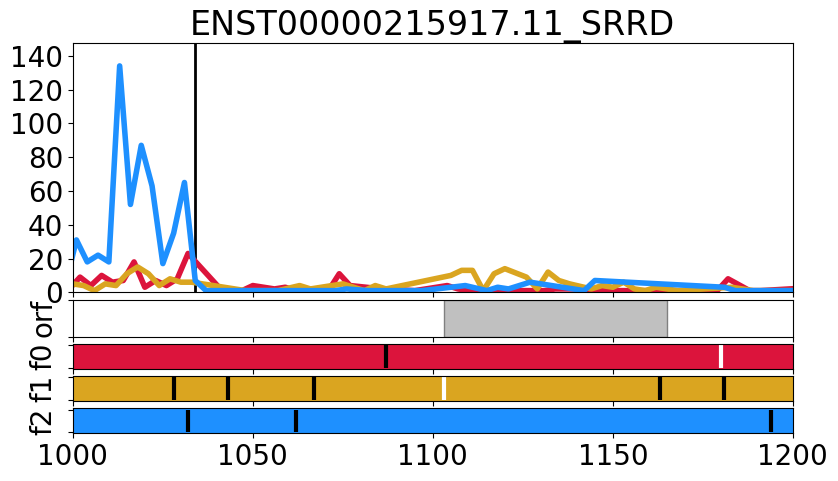

In [262]:
# EIF5	447	740	

# total_global[total_global['Global_Rank_within_ORF_type'] == '800']

# ST3GAL2	ENST00000393640	1944	2030	
#gene = 'EIF5'

#tr_id = 'ENST00000216554'

# start and stop 
#pre_st = '447_740'

xlims = [1000, 1200]

d1 = prepare_data_for_trips_frames_no_CDS(meta = metadata_pc_g25, 
                           file_counts = 'DATA/profiles/SELECTED_in_HLA/dORF_ENST00000215917.csv', 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =20, 
                             fraq =50, 
                             cds = False,
                             name = 't.png', 
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False,
                            frames=[1,2, 3],
                            cds_stop_pos_plot=True
                           )

trips_full_frames(d1, name = 't.png', font1=20, font2=24)

# SELECTED in HLA doORF

In [242]:
i = 19

a = found_ORFs.sort_values(by='Global_Rank_within_ORF_type').iloc[i]

print (a['Amino acid sequence'], a['peptide'])

pre_st = str(a.Start)+'_'+str(a.Stop)

tr_id = a.tr_id

gene = a.Gene

print (a.Type_of_ORF, gene, tr_id, pre_st, 'rank:', a.Global_Rank_within_ORF_type)

MVAETPLRGLHPPVLSLPTRRGELPLKQSY GELPLKQSY
odorf CA11 ENST00000084798.8 1657_1749 rank: 80


In [243]:
!ls DATA/profiles/SELECTED_in_HLA/doORF_ENST00000084798.csv


doORF_ENST00000084798.csv   nORF_ENST00000261507.csv   uORF_ENST00000256015.csv
lncORF_ENST00000473756.csv  uoORF_ENST00000216554.csv


30
0


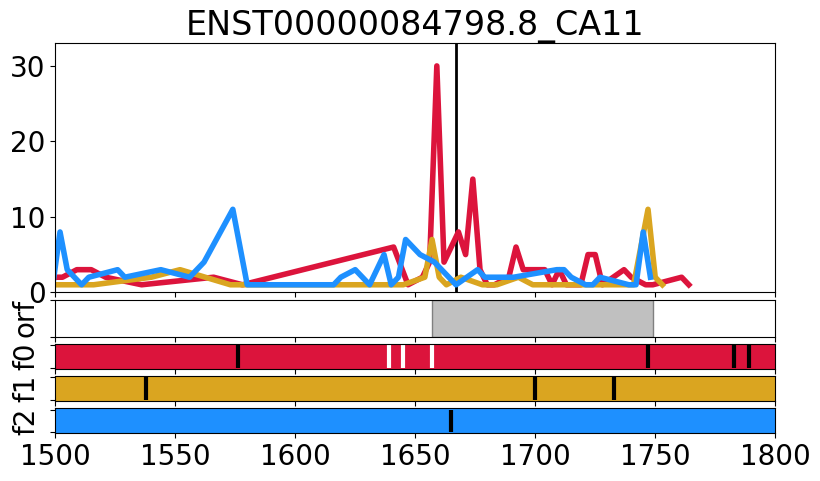

In [248]:
# EIF5	447	740	

# total_global[total_global['Global_Rank_within_ORF_type'] == '800']

# ST3GAL2	ENST00000393640	1944	2030	
#gene = 'EIF5'

#tr_id = 'ENST00000216554'

# start and stop 
#pre_st = '447_740'

xlims = [1500, 1800]

d1 = prepare_data_for_trips_frames_no_CDS(meta = metadata_pc_g25, 
                           file_counts = 'DATA/profiles/SELECTED_in_HLA/doORF_ENST00000084798.csv', 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =10, 
                             fraq =50, 
                             cds = False,
                             name = 't.png', 
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False,
                            frames=[1,2, 3],
                            cds_stop_pos_plot=True
                           )

trips_full_frames(d1, name = 't.png', font1=20, font2=24)

# SELECTED in HLA lncoRF

In [231]:
i = 13

a = found_ORFs.sort_values(by='Global_Rank_within_ORF_type').iloc[i]

print (a['Amino acid sequence'], a['peptide'])

pre_st = str(a.Start)+'_'+str(a.Stop)

tr_id = a.tr_id

gene = a.Gene

print (a.Type_of_ORF, gene, tr_id, pre_st, 'rank:', a.Global_Rank_within_ORF_type)

MWTVVAAPELTLTAHDSSVGEVGGFLEEEVWVMKPQRFADTFARHDFWSFRKLFCGFINKVFPSCVTPSHCYLFPWN EEEVWVMKP
noncoding LINC00973 ENST00000473756.1 17_250 rank: 53


In [232]:
!ls DATA/profiles/SELECTED_in_HLA/lncORF_ENST00000473756.csv

lncORF_ENST00000473756.csv  uoORF_ENST00000216554.csv
nORF_ENST00000261507.csv    uORF_ENST00000256015.csv


300
0


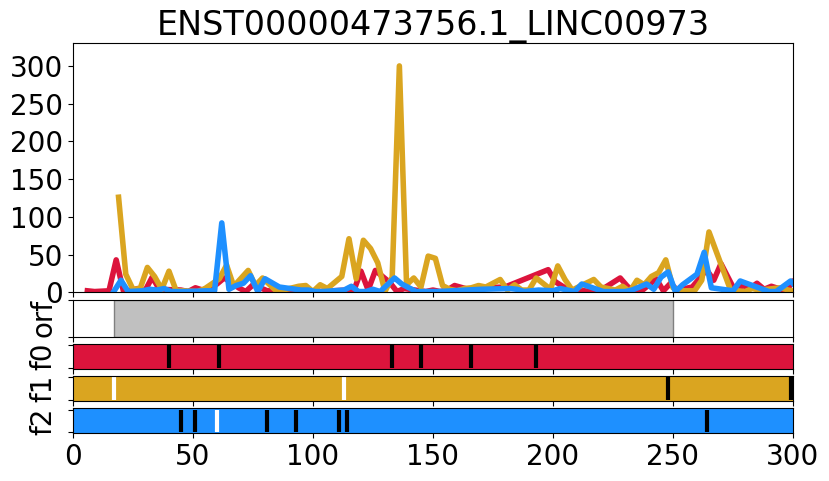

In [236]:
# EIF5	447	740	

# total_global[total_global['Global_Rank_within_ORF_type'] == '800']

# ST3GAL2	ENST00000393640	1944	2030	
#gene = 'EIF5'

#tr_id = 'ENST00000216554'

# start and stop 
#pre_st = '447_740'

xlims = [0, 300]

d1 = prepare_data_for_trips_frames_no_CDS(meta = metadata_pc_g25, 
                           file_counts = 'DATA/profiles/SELECTED_in_HLA/lncORF_ENST00000473756.csv', 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =50, 
                             fraq =50, 
                             cds = False,
                             name = 't.png', 
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False,
                            frames=[1,2, 3]
                           )

trips_full_frames(d1, name = 't.png', font1=20, font2=24)

# SELECTED in HLA nORF

In [223]:
i = 8

a = found_ORFs.sort_values(by='Global_Rank_within_ORF_type').iloc[i]

print (a['Amino acid sequence'], a['peptide'])

pre_st = str(a.Start)+'_'+str(a.Stop)

tr_id = a.tr_id

gene = a.Gene

print (a.Type_of_ORF, gene, tr_id, pre_st, 'rank:', a.Global_Rank_within_ORF_type)

MGKPMEVFQSSSL KPMEVFQSSSL
nested MSMO1 ENST00000261507.10 443_484 rank: 36


In [224]:
!ls DATA/profiles/SELECTED_in_HLA/

nORF_ENST00000261507.csv  uoORF_ENST00000216554.csv  uORF_ENST00000256015.csv


1890
0


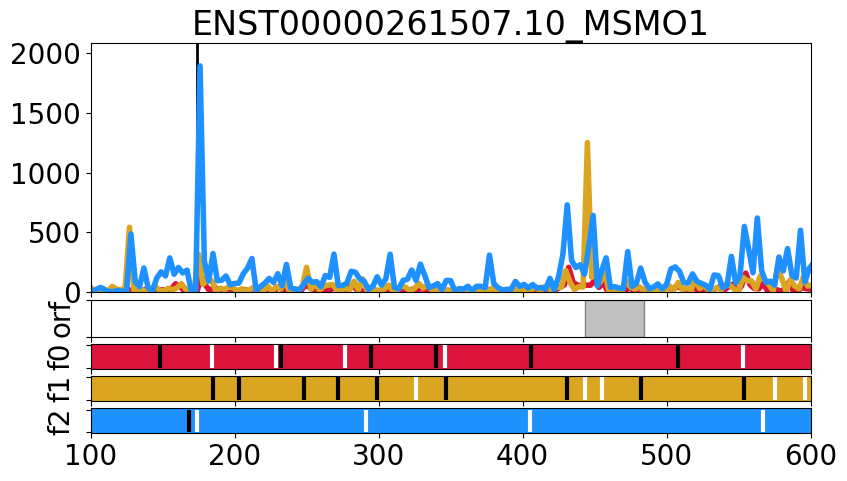

In [226]:
# EIF5	447	740	

# total_global[total_global['Global_Rank_within_ORF_type'] == '800']

# ST3GAL2	ENST00000393640	1944	2030	
#gene = 'EIF5'

#tr_id = 'ENST00000216554'

# start and stop 
#pre_st = '447_740'

xlims = [100, 600]

d1 = prepare_data_for_trips_frames_no_CDS(meta = metadata_pc_g25, 
                           file_counts = 'DATA/profiles/SELECTED_in_HLA/nORF_ENST00000261507.csv', 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =500, 
                             fraq =100, 
                             cds = False,
                             name = 't.png', 
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False,
                            frames=[1,2, 3]
                           )

trips_full_frames(d1, name = 't.png', font1=20, font2=24)

# SELECTED in HLA uORF

In [210]:
i = 1

a = found_ORFs.sort_values(by='Global_Rank_within_ORF_type').iloc[i]

print (a['Amino acid sequence'], a['peptide'])

pre_st = str(a.Start)+'_'+str(a.Stop)

tr_id = a.tr_id

gene = a.Gene

print (a.Type_of_ORF, gene, tr_id, pre_st, 'rank:', a.Global_Rank_within_ORF_type)

MQLLRSSNAAELEAEAAGEVRAM AEAAGEVRA
uorf BTG1 ENST00000256015.4 70_141 rank: 20


In [212]:
!ls DATA/profiles/SELECTED_in_HLA/

uoORF_ENST00000216554.csv  uORF_ENST00000256015.csv


4653
0


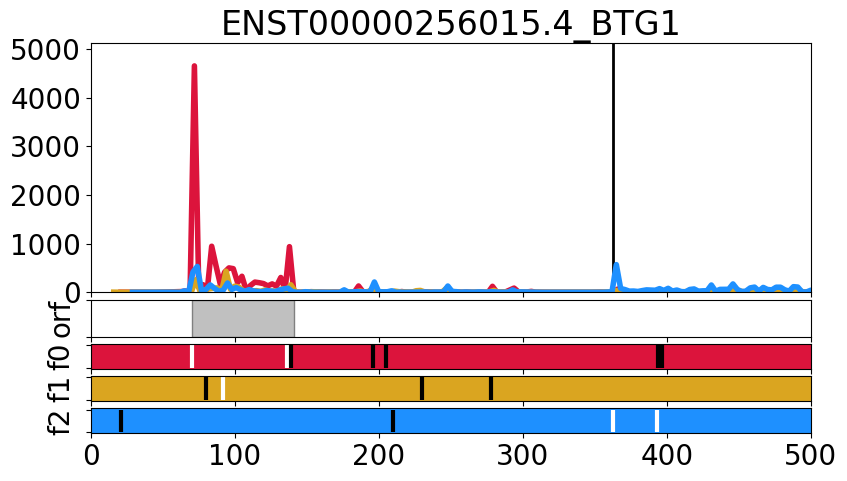

In [214]:
# EIF5	447	740	

# total_global[total_global['Global_Rank_within_ORF_type'] == '800']

# ST3GAL2	ENST00000393640	1944	2030	
#gene = 'EIF5'

#tr_id = 'ENST00000216554'

# start and stop 
#pre_st = '447_740'

xlims = [0, 500]

d1 = prepare_data_for_trips_frames_no_CDS(meta = metadata_pc_g25, 
                           file_counts = 'DATA/profiles/SELECTED_in_HLA/uORF_ENST00000256015.csv', 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =1000, 
                             fraq =100, 
                             cds = False,
                             name = 't.png', 
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False,
                            frames=[1,2, 3]
                           )

trips_full_frames(d1, name = 't.png', font1=20, font2=24)

# SELECTED in HLA, uoORF

In [187]:
!ls DATA/profiles/SELECTED_in_HLA/uoORF_ENST00000216554.csv

uoORF_ENST00000216554.csv


In [ ]:
# 428	520

8222
0


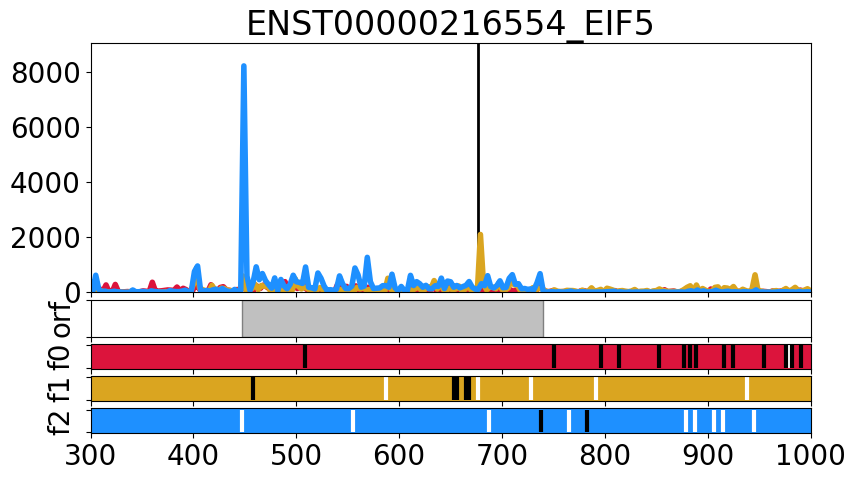

In [194]:
# EIF5	447	740	

# total_global[total_global['Global_Rank_within_ORF_type'] == '800']

# ST3GAL2	ENST00000393640	1944	2030	
gene = 'EIF5'

tr_id = 'ENST00000216554'

# start and stop 
pre_st = '447_740'

xlims = [300, 1000]

d1 = prepare_data_for_trips_frames_no_CDS(meta = metadata_pc_g25, 
                           file_counts = 'DATA/profiles/SELECTED_in_HLA/uoORF_ENST00000216554.csv', 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =2000, 
                             fraq =100, 
                             cds = False,
                             name = 't.png', 
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False,
                            frames=[1,2, 3]
                           )

trips_full_frames(d1, name = 't.png', font1=20, font2=24)

# doORF rank 200

In [171]:
!ls DATA/profiles/doORF

doORF_ENST00000380871_rank200.csv  dORF_ENST00000396418_rank100.csv
doORF_ENST00000556551_rank1.csv


In [176]:
total_global[(total_global['Global_Rank_within_ORF_type'] == '110') & 
            (total_global['Type_of_ORF'].str.contains('odorf'))]

,Gene,tr_id1,Start,Stop,Global_Rank_within_ORF_type,Type_of_ORF,Amino acid sequence,tr_id,group,strand,global_coo
79522,PKIA,ENST00000396418,650,730,110,odorf,MHNEVLQNKVGKPREKQQNLKANTPL,ENST00000396418.6,79523,+,chr8:78601754-78601834


In [181]:
a = total_global[(total_global['Global_Rank_within_ORF_type'] == '110') & 
            (total_global['Type_of_ORF'].str.contains('odorf'))].iloc[0]

gene = a.Gene
tr_id = a.tr_id1
pre_st = str(int(a.Start)) +'_'+str(int(a.Stop)-3)

pre_st, gene, tr_id

('650_727', 'PKIA', 'ENST00000396418')

44
0


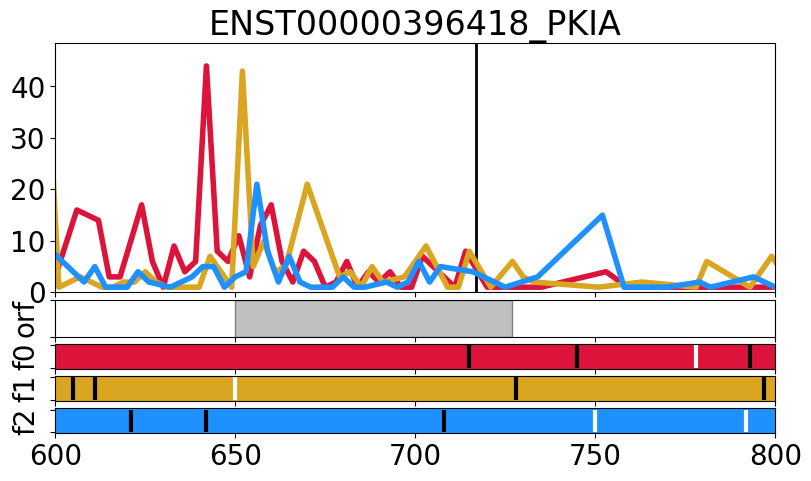

In [182]:
# ST3GAL2	ENST00000393640	1944	2030	
#gene = 'VWA7'

#tr_id = 'ENST00000375688'

# start and stop 
#pre_st = '185_346'

xlims = [600, 800]

d1 = prepare_data_for_trips_frames_no_CDS(meta = metadata_pc_g25, 
                           file_counts = 'DATA/profiles/doORF/dORF_ENST00000396418_rank110.csv', 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =10, 
                             fraq =50, 
                             cds = False,
                             name = 't.png', 
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False,
                            frames=[1,2, 3],
                            cds_stop_pos_plot=True
                           )

trips_full_frames(d1, name = 't.png', font1=20, font2=24)

# doORF rank1 

In [132]:
!ls DATA/profiles/doORF

doORF_ENST00000380871_rank200.csv  doORF_ENST00000556551_rank1.csv


In [150]:
total_global['Type_of_ORF'].unique()

array(['uorf', 'nested', 'odorf', 'dorf', 'ouorf', 'noncoding'],
      dtype=object)

In [151]:
a = total_global[(total_global['Global_Rank_within_ORF_type'] == '1') & 
            (total_global['Type_of_ORF'].str.contains('odorf'))].iloc[0]

gene = a.Gene
tr_id = a.tr_id1
pre_st = str(int(a.Start)) +'_'+str(int(a.Stop))

pre_st, gene, tr_id

('1054_1086', 'RP5-1021I20.4', 'ENST00000556551')

2258
0


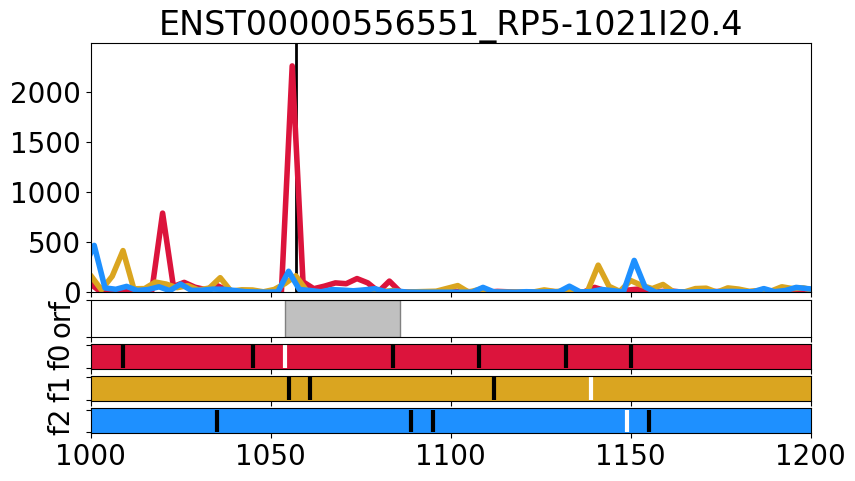

In [158]:
# ST3GAL2	ENST00000393640	1944	2030	
#gene = 'VWA7'

#tr_id = 'ENST00000375688'

# start and stop 
#pre_st = '185_346'

xlims = [1000, 1200]

d1 = prepare_data_for_trips_frames_no_CDS(meta = metadata_pc_g25, 
                           file_counts = 'DATA/profiles/doORF/doORF_ENST00000556551_rank1.csv', 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =500, 
                             fraq =50, 
                             cds = False,
                             name = 't.png', 
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False,
                            frames=[1,2, 3],
                            cds_stop_pos_plot=True
                           )

trips_full_frames(d1, name = 't.png', font1=20, font2=24)

# dORF rank350

In [103]:
!ls DATA/profiles/dORF

dORF_ENST00000053468_rank700.csv  dORF_ENST00000374922_rank1.csv
dORF_ENST00000360315_rank348.csv  dORF_ENST00000507606_rank3.csv
dORF_ENST00000369825_rank350.csv  dORF_ENST00000507606_rank4.csv


In [115]:
a = total_global[(total_global['Global_Rank_within_ORF_type'] == '350') & 
            (total_global['Type_of_ORF'].str.contains('dorf'))].iloc[0]

gene = a.Gene
tr_id = a.tr_id1
pre_st = str(int(a.Start)) +'_'+str(int(a.Stop)-2)

pre_st, gene, tr_id

('661_700', 'USMG5', 'ENST00000369825')

4454
0


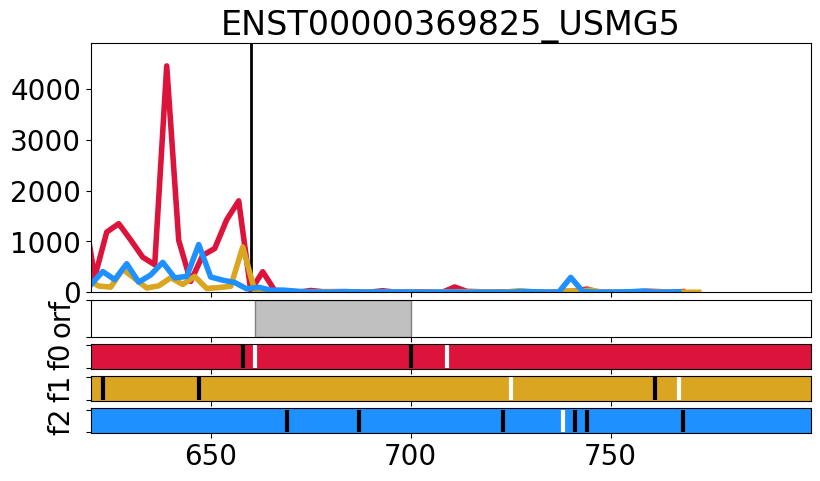

In [116]:
# ST3GAL2	ENST00000393640	1944	2030	
#gene = 'VWA7'

#tr_id = 'ENST00000375688'

# start and stop 
#pre_st = '185_346'

xlims = [620, 800]

d1 = prepare_data_for_trips_frames_no_CDS(meta = metadata_pc_g25, 
                           file_counts = 'DATA/profiles/dORF/dORF_ENST00000369825_rank350.csv', 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =1000, 
                             fraq =50, 
                             cds = False,
                             name = 't.png', 
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False,
                            frames=[1,2, 3],
                            cds_stop_pos_plot=True
                           )

trips_full_frames(d1, name = 't.png', font1=20, font2=24)

# dORF rank1

In [83]:
!ls DATA/profiles/dORF

dORF_ENST00000053468_rank700.csv  dORF_ENST00000507606_rank3.csv
dORF_ENST00000360315_rank348.csv  dORF_ENST00000507606_rank4.csv
dORF_ENST00000374922_rank1.csv


In [81]:
total_global['Type_of_ORF'].unique()

array(['uorf', 'nested', 'dorf', 'ouorf', 'noncoding'], dtype=object)

In [95]:
a = total_global[(total_global['Global_Rank_within_ORF_type'] == '1') & 
            (total_global['Type_of_ORF'].str.contains('dorf'))].iloc[0]

gene = a.Gene
tr_id = a.tr_id1
pre_st = str(int(a.Start)-5) +'_'+a.Stop

pre_st, gene, tr_id

('345_445', 'LINC01420', 'ENST00000374922')

630
0


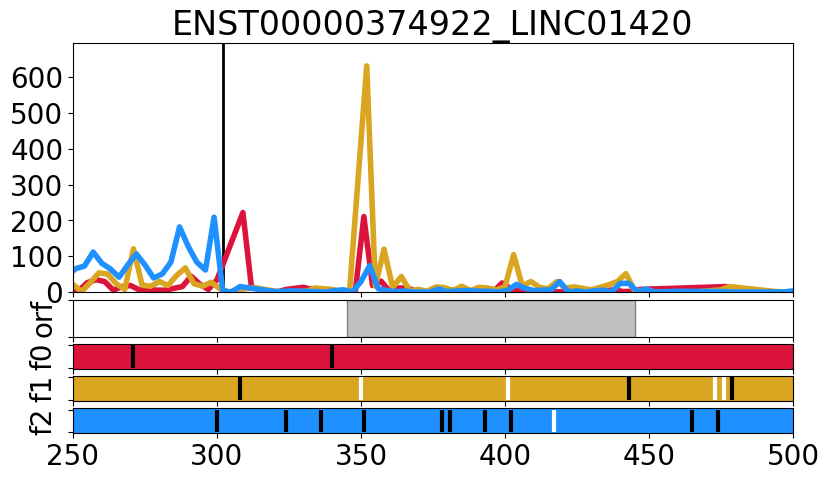

In [98]:
# ST3GAL2	ENST00000393640	1944	2030	
#gene = 'VWA7'

#tr_id = 'ENST00000375688'

# start and stop 
#pre_st = '185_346'

xlims = [250, 500]

d1 = prepare_data_for_trips_frames_no_CDS(meta = metadata_pc_g25, 
                           file_counts = 'DATA/profiles/dORF/dORF_ENST00000374922_rank1.csv', 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =100, 
                             fraq =50, 
                             cds = False,
                             name = 't.png', 
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False,
                            frames=[1,2, 3],
                            cds_stop_pos_plot=True
                           )

trips_full_frames(d1, name = 't.png', font1=20, font2=24)

# lncORF rank 2500 

In [70]:
!ls DATA/profiles/lncORF

lncORF_ENST00000399070_rank2900.csv  lncORF_ENST00000434409_rank2700.csv
lncORF_ENST00000410494_rank2500.csv  lncORF_ENST00000578296_rank3000.csv
lncORF_ENST00000429124_rank5000.csv  lncORF_ENST00000610973_rank1.csv
lncORF_ENST00000434244_rank1500.csv  lncORF_ENST00000624270_rank2000.csv


In [71]:
a = total_global[(total_global['Global_Rank_within_ORF_type'] == '2500') & 
            (total_global['Type_of_ORF'].str.contains('noncoding'))].iloc[0]

gene = a.Gene
tr_id = a.tr_id1
pre_st = a.Start +'_'+a.Stop

pre_st, gene, tr_id

('56_85', 'RNU2-50P', 'ENST00000410494')

267921
0


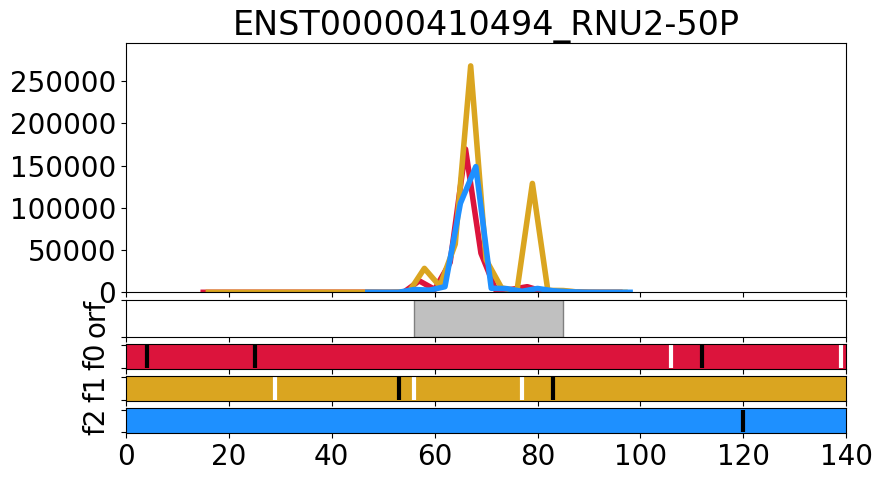

In [76]:
# ST3GAL2	ENST00000393640	1944	2030	
#gene = 'VWA7'

#tr_id = 'ENST00000375688'

# start and stop 
#pre_st = '185_346'

xlims = [0, 140]

d1 = prepare_data_for_trips_frames_no_CDS(meta = metadata_pc_g25, 
                           file_counts = 'DATA/profiles/lncORF/lncORF_ENST00000410494_rank2500.csv', 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =50000, 
                             fraq =20, 
                             cds = False,
                             name = 't.png', 
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False,
                            frames=[1,2, 3]
                           )

trips_full_frames(d1, name = 't.png', font1=20, font2=24)

# lncORF rank1

In [263]:
!ls DATA/profiles/lncORF

lncORF_ENST00000399070_rank2900.csv  lncORF_ENST00000434409_rank2700.csv
lncORF_ENST00000410494_rank2500.csv  lncORF_ENST00000578296_rank3000.csv
lncORF_ENST00000429124_rank5000.csv  lncORF_ENST00000610973_rank1.csv
lncORF_ENST00000434244_rank1500.csv  lncORF_ENST00000624270_rank2000.csv


In [268]:
a = total_global[(total_global['Global_Rank_within_ORF_type'] == '1') & 
            (total_global['Type_of_ORF'].str.contains('noncoding'))].iloc[0]

gene = a.Gene
tr_id = a.tr_id1
pre_st = a.Start +'_'+str(int(a.Stop)-2)

pre_st, gene, tr_id

('13_88', 'ZNFX1-AS1_2', 'ENST00000610973')

8234
0


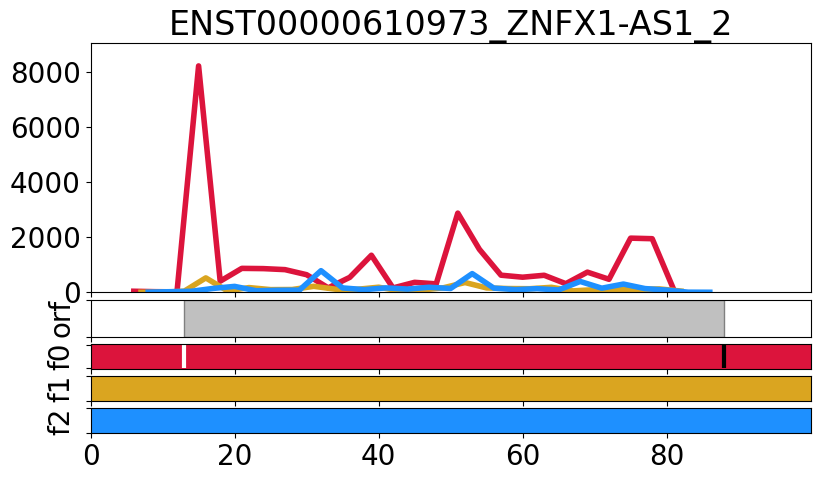

In [269]:
# ST3GAL2	ENST00000393640	1944	2030	
#gene = 'VWA7'

#tr_id = 'ENST00000375688'

# start and stop 
#pre_st = '185_346'

xlims = [0, 100]

d1 = prepare_data_for_trips_frames_no_CDS(meta = metadata_pc_g25, 
                           file_counts = 'DATA/profiles/lncORF/lncORF_ENST00000610973_rank1.csv', 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =2000, 
                             fraq =20, 
                             cds = False,
                             name = 't.png', 
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False,
                            frames=[1,2, 3]
                           )

trips_full_frames(d1, name = 't.png', font1=20, font2=24)

# nORF rank 950

In [191]:
!ls DATA/profiles/nORF/

nORF_ENST00000251089_rank950.csv  nORF_ENST00000381140_rank1.csv


In [192]:
a = total_global[(total_global['Global_Rank_within_ORF_type'] == '950') & 
            (total_global['Type_of_ORF'] == 'nested')].iloc[0]

gene = a.Gene
tr_id = a.tr_id1
pre_st = a.Start +'_'+a.Stop

pre_st, gene, tr_id

('178_237', 'ANGEL1', 'ENST00000251089')

In [193]:
total_global[(total_global['Global_Rank_within_ORF_type'] == '999') & 
            (total_global['Type_of_ORF'] == 'nested')]

,Gene,tr_id1,Start,Stop,Global_Rank_within_ORF_type,Type_of_ORF,Amino acid sequence,tr_id,group,strand,global_coo
195284,ABRACL,ENST00000367660,307,342,999,nested,MINVPTSLKHW,ENST00000367660.3,195285,+,chr6:139042764-139042799


In [194]:
# ST3GAL2	ENST00000393640	1944	2030	
#gene = 'VWA7'

#tr_id = 'ENST00000375688'

# start and stop 
#pre_st = '185_346'

xlims = [0, 700]

d1 = prepare_data_for_trips_frames_no_CDS(meta = metadata_pc_g25, 
                           file_counts = 'DATA/profiles/nORF/nORF_ENST00000251089_rank950.csv', 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =20, 
                             fraq =100, 
                             cds = False,
                             name = 't.png', 
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False,
                            frames=[1,2, 3]
                           )

trips_full_frames(d1, name = 't.png', font1=20, font2=24)

159
0
Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f7f3a4eb310> (for post_execute):


KeyError: (0.0, 8792.0, '8792', 'black', 'center_baseline', 'right', 8402822707810290242, None, None, 300, <weakref at 0x7f7f2c378900; to 'RendererAgg' at 0x7f7ec3df7cd0>, 1.2)

KeyError: (0.0, 8792.0, '8792', 'black', 'center_baseline', 'right', 8402822707810290242, None, None, 300, <weakref at 0x7f7f2c378900; to 'RendererAgg' at 0x7f7ec3df7cd0>, 1.2)

<Figure size 900x500 with 5 Axes>

# nORF rank 1

In [119]:
!ls DATA/profiles/nORF/

nORF_ENST00000381140_rank1.csv	nORF_ENST00000532917_rank400.csv


In [120]:
a = total_global[(total_global['Global_Rank_within_ORF_type'] == '1') & 
            (total_global['Type_of_ORF'] == 'nested')].iloc[0]

gene = a.Gene
tr_id = a.tr_id1
pre_st = a.Start +'_'+a.Stop

4236
0


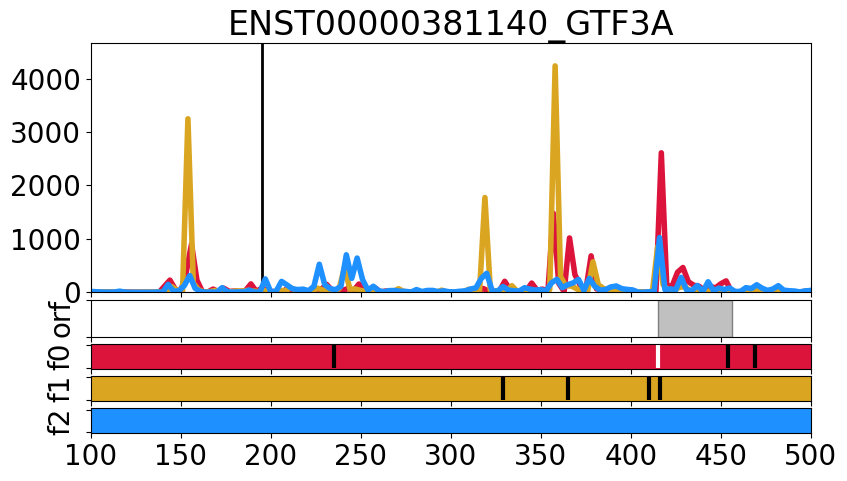

In [122]:
# ST3GAL2	ENST00000393640	1944	2030	
#gene = 'VWA7'

#tr_id = 'ENST00000375688'

# start and stop 
#pre_st = '185_346'

xlims = [100, 500]

d1 = prepare_data_for_trips_frames_no_CDS(meta = metadata_pc_g25, 
                           file_counts = 'DATA/profiles/nORF/nORF_ENST00000381140_rank1.csv', 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =1000, 
                             fraq =50, 
                             cds = False,
                             name = 't.png', 
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False,
                            frames=[1,2, 3]
                           )

trips_full_frames(d1, name = 't.png', font1=20, font2=24)

# uoORF rank 800

In [112]:
total_global[total_global['Global_Rank_within_ORF_type'] == '800']

,Gene,tr_id1,Start,Stop,Global_Rank_within_ORF_type,Type_of_ORF,Amino acid sequence,tr_id,group,strand,global_coo
19131,SLC45A3,ENST00000367145,77,121,800,uorf,MRRVPTEVPHSSRC,ENST00000367145.3,19132,-,chr1:205664832-205664876
115534,ARL1,ENST00000261636,412,462,800,nested,MLLFKHRCSHLCSRQL,ENST00000261636.12,115535,-,chr12:101401111-101401161
167768,VWA7,ENST00000375688,191,346,800,ouorf,MSQPCSPRRSPNPTRAPQRCFCCSCCCPPHLPSSPTSGACWLPLAP...,ENST00000375688.4,167769,-,chr6:31776635-31776790
340103,RAC1,ENST00000348035,2261,2296,800,dorf,MQLALCFACMT,ENST00000348035.8,340104,+,chr7:6403915-6403950
391505,LINC00152,ENST00000409054,50,154,800,noncoding,MSHLVPMRMKAEVCAFFFFSFLVVCTSLGMEGNK,ENST00000409054.1,391506,+,chr2:87455417-87455521


In [111]:
!ls DATA/profiles/uoORF

uoORF_ENST00000250498_rank700.csv  uoORF_ENST00000382142_rank500.csv
uoORF_ENST00000304385_rank599.csv  uoORF_ENST00000382564_rank1.csv
uoORF_ENST00000342494_rank550.csv  uoORF_ENST00000457167_rank699.csv
uoORF_ENST00000375688_rank800.csv


68
0


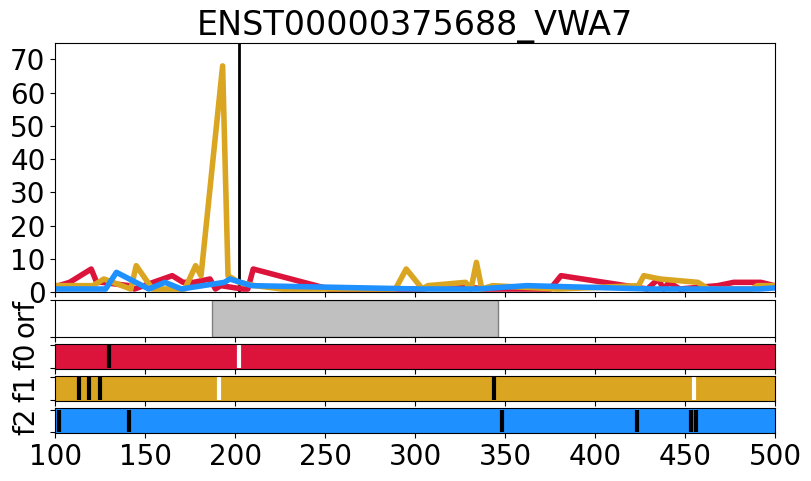

In [271]:
# !ls DATA/profiles/uoORF

# total_global[total_global['Global_Rank_within_ORF_type'] == '800']

# ST3GAL2	ENST00000393640	1944	2030	
gene = 'VWA7'

tr_id = 'ENST00000375688'

# start and stop 
pre_st = '187_346'

xlims = [100, 500]

d1 = prepare_data_for_trips_frames_no_CDS(meta = metadata_pc_g25, 
                           file_counts = 'DATA/profiles/uoORF/uoORF_ENST00000375688_rank800.csv', 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =10, 
                             fraq =50, 
                             cds = False,
                             name = 't.png', 
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False,
                            frames=[1,2, 3]
                           )

trips_full_frames(d1, name = 't.png', font1=20, font2=24)

# uoORF rank 600

In [107]:
!ls DATA/profiles/uoORF/

uoORF_ENST00000250498_rank700.csv  uoORF_ENST00000382142_rank500.csv
uoORF_ENST00000304385_rank599.csv  uoORF_ENST00000382564_rank1.csv
uoORF_ENST00000342494_rank550.csv  uoORF_ENST00000457167_rank699.csv


In [108]:
total_global[total_global['Global_Rank_within_ORF_type'] == '599']

,Gene,tr_id1,Start,Stop,Global_Rank_within_ORF_type,Type_of_ORF,Amino acid sequence,tr_id,group,strand,global_coo
14623,OSR2,ENST00000297565,58,144,599,uorf,MALQGCGLRPHRESTARGSPKSEVLGER,ENST00000297565.8,14624,+,chr8:98944499-98944585
165227,TMEM154,ENST00000304385,163,300,599,ouorf,MFTFQRGCSPAQHPERASAEASGHAGSPRSPSLRPGDRARSRRPG,ENST00000304385.7,165228,-,chr4:152652924-152652927+chr4:152679870-152680003
188371,CTDSP2,ENST00000398073,1272,1301,599,dorf,MPSGRMPDQ,ENST00000398073.6,188372,-,chr12:57823421-57823450
191110,COMMD8,ENST00000381571,154,234,599,nested,MAFVVELILCTKIITLFGNQKNGCTF,ENST00000381571.5,191111,-,chr4:47460200-47460280
392845,SNHG1,ENST00000538654,833,901,599,noncoding,MAELSSDVILLLRSEREVLRGL,ENST00000538654.5,392846,-,chr11:62854985-62855053


133
0


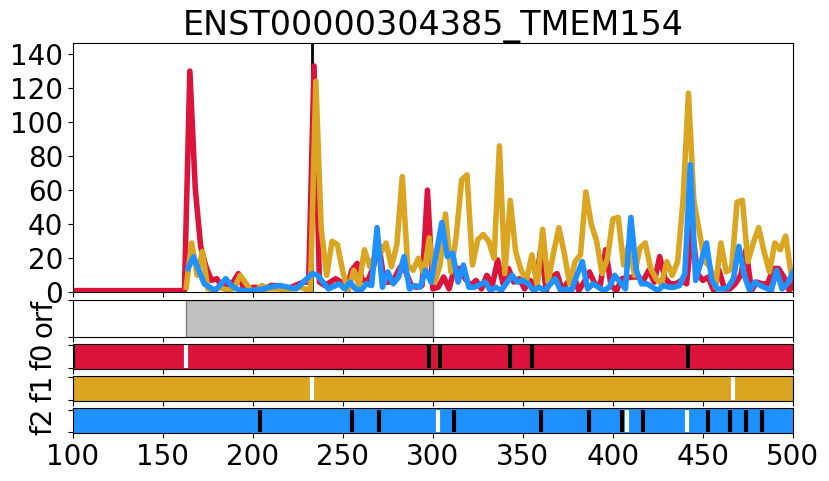

In [110]:
# ST3GAL2	ENST00000393640	1944	2030	
gene = 'TMEM154'

tr_id = 'ENST00000304385'

# start and stop 
pre_st = '163_300'

xlims = [100, 500]

d1 = prepare_data_for_trips_frames_no_CDS(meta = metadata_pc_g25, 
                           file_counts = 'DATA/profiles/uoORF/uoORF_ENST00000304385_rank599.csv', 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =20, 
                             fraq =50, 
                             cds = False,
                             name = 't.png', 
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False,
                            frames=[1,2, 3]
                           )

trips_full_frames(d1, name = 't.png', font1=20, font2=24)

# uoORF rank 1 

6286
0


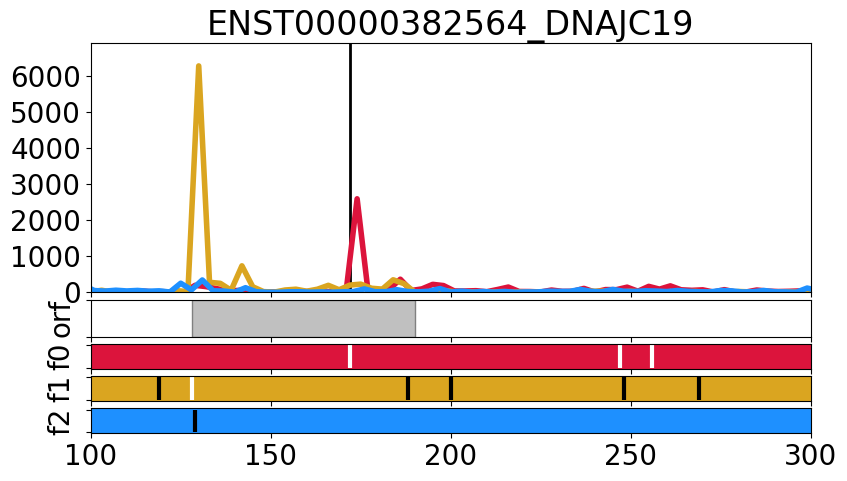

In [106]:
# ST3GAL2	ENST00000393640	1944	2030	
gene = 'DNAJC19'

tr_id = 'ENST00000382564'

# start and stop 
pre_st = '128_190'

xlims = [100, 300]

d1 = prepare_data_for_trips_frames_no_CDS(meta = metadata_pc_g25, 
                           file_counts = 'DATA/profiles/uoORF/uoORF_ENST00000382564_rank1.csv', 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =1000, 
                             fraq =50, 
                             cds = False,
                             name = 't.png', 
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False,
                            frames=[1,2, 3]
                           )

trips_full_frames(d1, name = 't.png', font1=20, font2=24)

# uORF rank 6200

48
0


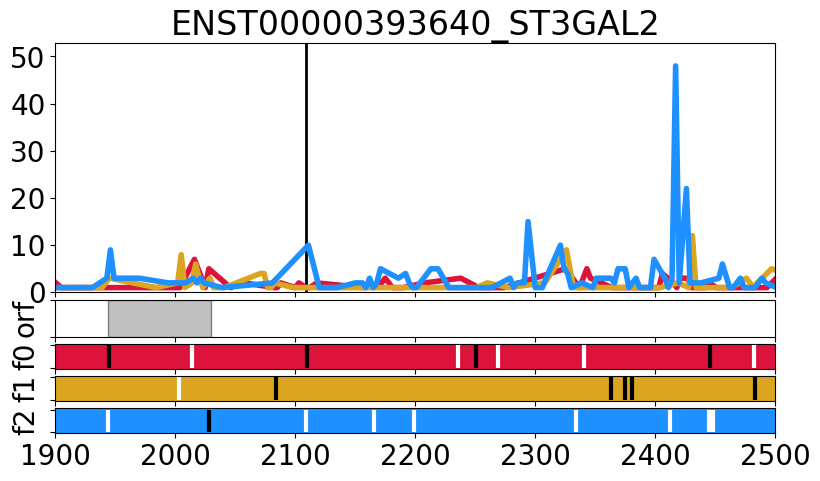

In [94]:
# ST3GAL2	ENST00000393640	1944	2030	
gene = 'ST3GAL2'

tr_id = 'ENST00000393640'

# start and stop 
pre_st = '1944_2030'

xlims = [1900,2500]

d1 = prepare_data_for_trips_frames_no_CDS(meta = metadata_pc_g25, 
                           file_counts = 'DATA/profiles/uORF/uORF_ENST00000393640_rank6200.csv', 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =10, 
                             fraq =100, 
                             cds = False,
                             name = 't.png', 
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False,
                            frames=[1,2, 3]
                           )

trips_full_frames(d1, name = 't.png', font1=20, font2=24)

# uORF rank 5000

204
0


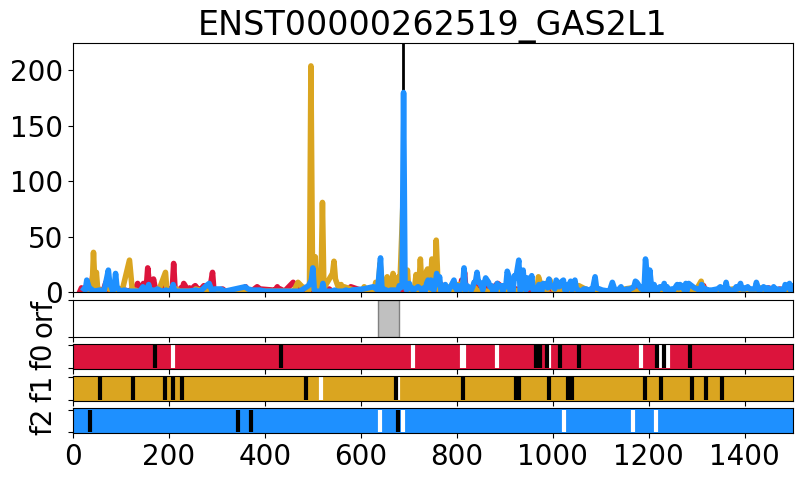

In [87]:
gene = 'GAS2L1'

tr_id = 'ENST00000262519'

# start and stop 
pre_st = '636_680'

xlims = [0,1500]

d1 = prepare_data_for_trips_frames_no_CDS(meta = metadata_pc_g25, 
                           file_counts = 'DATA/profiles/uORF/uORF_ENST00000262519_rank5000.csv', 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =50, 
                             fraq =200, 
                             cds = False,
                             name = 't.png', 
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False,
                            frames=[1,2, 3]
                           )

trips_full_frames(d1, name = 't.png', font1=20, font2=24)

# uORF, rank 6300 

# uORF, rank1

6789
0


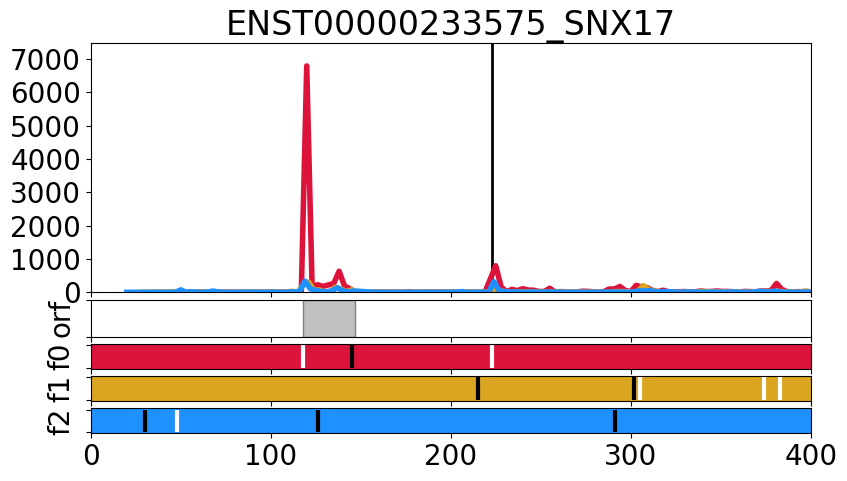

In [73]:
gene = 'SNX17'

tr_id = 'ENST00000233575'

# start and stop 
pre_st = '118_147'

xlims = [0, 400]

d1 = prepare_data_for_trips_frames_no_CDS(meta = metadata_pc_g25, 
                           file_counts = 'DATA/profiles/uORF/uORF_ENST00000233575_rank1.csv', 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id,                 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =1000, 
                             fraq =100, 
                             cds = False,
                             name = 't.png', 
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False,
                            frames=[1,2, 3]
                           )

trips_full_frames(d1, name = 't.png', font1=20, font2=24)